# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline
from tqdm import tqdm

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_test.csv')

print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.loc[0, "Text"])

strong taste but good! In my opinion it's not exactly a substitute for coffee but tastes really good mixed together.


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      207103        112082  112083  B002Y2QT2K  A22Y5TJPN98DWB   
1      139933        224640  224641  B009D53XKC  A3MDY6Y3Z6D649   
2       76100        399707  399708  B005GIF5WY  A3LCQXQ4SFYBAU   
3      114178        567900  567901  B005K4Q68Q  A2E65ZXD654761   
4      285272        263134  263135  B002WW3BW8  A1XAZ0MR4TRY16   

                  ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                Eva Juergens                     1                       1   
1  The Man Behind the Curtain                     1                       1   
2                  Johna Jane                     0                       0   
3                   Barbara L                     0                       0   
4                        bfn1                     0                       0   

   Score        Time                          Summary  \
0      3  1339286400                 chicory "coffee"   
1      5

In [5]:
##study chat

print(amazon[(amazon.helpful == True) &  (amazon.HelpfulnessNumerator>=5)] )

       Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
7           74160        306680  306681  B000KNB0OW  A1UQBFCERIP7VJ   
14         235629        224160  224161  B0002ARQYQ  A2T90OFSZ5QVE8   
19         261341        100841  100842  B000O3EDA6  A1VPUK22B4MTDE   
20         218022        107544  107545  B007TJGY4Q  A153ZN281OATI6   
28         348320        246292  246293  B0009F3SB4  A23C3X5UGN7KMN   
43         398064        506166  506167  B001CWVZUY  A1UKN7G4AM275R   
57         268338        352657  352658  B000U3H4PQ   AYB4ELCS5AM8P   
64          14378        464995  464996  B002EDIJCM  A191T1D7JURDMI   
83         306766        551822  551823  B003RDFJ6C  A3NID9D9WMIV01   
148        159725         45277   45278  B000OV5NBG  A3OQGS2G48ZURR   
175         34171        417148  417149  B00112ILZM  A3FNMPXHHIVEYT   
181         24886        447330  447331  B000GZU900  A1WXJ1I42UOQ2V   
191        183906        394423  394424  B00269VK20  A154PTQXC5FFKH   
202   

In [6]:
# from gensim.parsing.preprocessing import remove_stopwords
# # remove stop words in amazon.Text
# amazon['Text'] = amazon['Text'].apply(remove_stopwords)
# #newText = amazon['Text'].apply(remove_stopwords)
# print(amazon.Text)

In [7]:
#Lemmatization 
from gensim.utils import lemmatize
print('**************************************************')
amaLemma=[]
for w in tqdm(amazon['Text']):
    amaLemma.append([wd.decode('utf-8').split('/')[0] for wd in lemmatize(w)])

  0%|          | 0/91000 [00:00<?, ?it/s]

**************************************************


100%|██████████| 91000/91000 [11:09<00:00, 136.01it/s]


In [373]:
amaNp=np.array(amaLemma)
amaDF=pd.DataFrame(amaNp)

amaDF.to_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/AmazonLemmatizedTestingwithStopWords.csv')
print(amaDF)

                                                       0
0      [strong, taste, good, opinion, not, exactly, s...
1      [search, high, low, salt, change, life, end, j...
2      [treat, be, picky, cat, favorite, ve, try, dif...
3      [price, be, fantastic, taste, so, convenient, ...
4      [alot, chocolate, not, so, much, coffee, bean,...
5      [look, ingredient, water, wheat, salt, sugar, ...
6      [love, love, bread, mix, person, be, raise, ea...
7      [country, choice, brand, be, domestically, pro...
8      [taste, good, easy, prepare, separate, pouch, ...
9      [only, recently, have, discover, satisy, inter...
10     [always, enjoy, tazo, tea, earl, grey, be, fav...
11     [be, skeptical, sister, tell, drug, rep, have,...
12     [have, grand, kid, fall, play, ground, equipme...
13     [guess, get, title, wrong, be, food, left, be,...
14     [buy, mini, buster, cube, miniature, dachshund...
15     [ll, confess, know, little, different, coffee,...
16     [be, thrill, find, flavo

In [374]:
#JOIN LIST TO STR


amaDFOut = amaDF[0].apply(' '.join)
print(amaDFOut.head())


0    strong taste good opinion not exactly substitu...
1    search high low salt change life end journey m...
2    treat be picky cat favorite ve try different b...
3    price be fantastic taste so convenient make me...
4    alot chocolate not so much coffee bean not big...
Name: 0, dtype: object


### Feature extraction on natural language data

In [375]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())
hv = joblib.load('vectorizer.pkl')
X_hv = hv.transform(amaDFOut)
print(X_hv.shape)

(91000, 76362)


In [376]:
# # vectorize Bag of Words from review text; as sparse matrix
# # from sklearn.feature_extraction.text import HashingVectorizer
# # hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# hv = joblib.load('hv.pkl')
# #X_hv = hv.transform(amazon.Text)
# X_hv = hv.transform(amaDFOut)
# print(X_hv.shape)
# # print(hv.shape)

In [377]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [378]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Time Converting 

In [379]:
import datetime

amazon['amaRead'] = amazon['Time'].apply(datetime.datetime.fromtimestamp)
amazon['amaMonth'] = amazon['amaRead'].apply(datetime.datetime.strftime, format=("%m"))
amazon['amaMonth'] = amazon['amaMonth'].apply(int)
amazon['amaDay'] =amazon['amaRead'].apply(datetime.datetime.weekday)

amazon['amaYear']=amazon['amaRead'].apply(datetime.datetime.strftime, format=("%Y"))
amazon['amaYear']= amazon['amaYear'].apply(int)


print(amazon['amaYear'].head(10))
print(amazon['amaMonth'].head(10))
print(amazon['amaDay'].head(10))

0    2012
1    2012
2    2012
3    2012
4    2011
5    2012
6    2011
7    2010
8    2010
9    2008
Name: amaYear, dtype: int64
0     6
1     1
2     8
3    10
4     7
5    10
6     3
7     2
8    10
9     2
Name: amaMonth, dtype: int64
0    5
1    1
2    6
3    1
4    6
5    2
6    0
7    4
8    0
9    6
Name: amaDay, dtype: int64


### Create additional quantitative features

In [380]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()
amazon['reviewLenAfterLe'] = amaDFOut.str.len()
# X_quant_features = amazon[["Score", "reviewLen"]]
# X_quant_features = amazon[["Score", "reviewLen","amaDay","amaHour"]]
amazon['revPlusScore']=  amazon['reviewLen']*amazon['Score']
amazon['revLenMinLe']=amazon['reviewLen']-amazon['reviewLenAfterLe']

X_quant_features = amazon[["reviewLen","Score","reviewLenAfterLe","amaDay", "amaMonth", "revPlusScore", "amaYear","revLenMinLe"]]

print(X_quant_features.head(10))
print(type(X_quant_features))

   reviewLen  Score  reviewLenAfterLe  amaDay  amaMonth  revPlusScore  \
0        116      3                88       5         6           348   
1       2915      5              1911       1         1         14575   
2        152      5                97       6         8           760   
3        167      5               109       1        10           835   
4        120      3                90       6         7           360   
5        193      1               133       2        10           193   
6        732      5               428       0         3          3660   
7       1122      5               792       4         2          5610   
8         88      5                59       0        10           440   
9        549      5               390       6         2          2745   

   amaYear  revLenMinLe  
0     2012           28  
1     2012         1004  
2     2012           55  
3     2012           58  
4     2011           30  
5     2012           60  
6     2011    

### Combine all quantitative features into a single sparse matrix

In [381]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 76370)


### Create `X`, scaled matrix of features

In [382]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
# X = sc.transform(sc)
print(X.shape)
print(X_matrix.shape)

(91000, 76370)
(91000, 76370)


### create `y`, vector of Labels

In [383]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [396]:
# MODEL: ordinary least squares
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X, y)
# joblib.dump(ols, 'ols.pkl') # pickle
ols = joblib.load('ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 6529, 'TN': 690, 'FP': 83703, 'FN': 78, 'Accuracy': 0.07932967032967032, 'Precision': 0.07235792180157816, 'Recall': 0.9881943393370668, 'desc': 'ols'}


In [397]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1751, 'TN': 80676, 'FP': 3717, 'FN': 4856, 'Accuracy': 0.9057912087912088, 'Precision': 0.3202267739575713, 'Recall': 0.2650219464204632, 'desc': 'svm'}


In [398]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 3200, 'TN': 71327, 'FP': 13066, 'FN': 3407, 'Accuracy': 0.8189780219780219, 'Precision': 0.19672937415467848, 'Recall': 0.4843347964280309, 'desc': 'lgs'}


In [399]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2083, 'TN': 76226, 'FP': 8167, 'FN': 4524, 'Accuracy': 0.8605384615384616, 'Precision': 0.20321951219512194, 'Recall': 0.31527168154987134, 'desc': 'nbs'}


In [400]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2396, 'TN': 77086, 'FP': 7307, 'FN': 4211, 'Accuracy': 0.8734285714285714, 'Precision': 0.2469339379573328, 'Recall': 0.3626456788254881, 'desc': 'prc'}


In [401]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 891, 'TN': 83325, 'FP': 1068, 'FN': 5716, 'Accuracy': 0.9254505494505495, 'Precision': 0.4548238897396631, 'Recall': 0.13485696988042983, 'desc': 'rdg'}


In [402]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2669, 'TN': 81527, 'FP': 2866, 'FN': 3938, 'Accuracy': 0.9252307692307692, 'Precision': 0.4822041553748871, 'Recall': 0.40396549114575453, 'desc': 'dtc'}


In [403]:
# MODEL: Randomforest

rfc = joblib.load('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/rfc.pkl')
rfc_performance = BinaryClassificationPerformance(rfc.predict(X_matrix), y, 'rfc')
rfc_performance.compute_measures()
print(rfc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1605, 'TN': 84363, 'FP': 30, 'FN': 5002, 'Accuracy': 0.9447032967032967, 'Precision': 0.981651376146789, 'Recall': 0.24292417133343425, 'desc': 'rfc'}


### ROC plot to compare performance of various models and fits

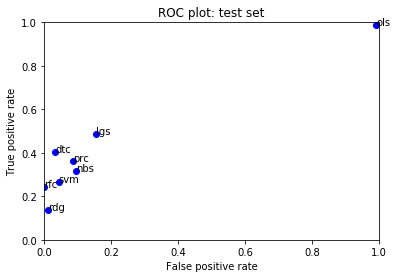

In [404]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance,rfc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [127]:
amazon.loc[0, "Text"]

"strong taste but good! In my opinion it's not exactly a substitute for coffee but tastes really good mixed together."

In [128]:
amazon.loc[0, "helpful"]

False

In [129]:
ridge_predictions = rdg.predict(X)

In [130]:
ridge_predictions.shape

(91000,)

In [131]:
print(ridge_predictions)

[False False False ... False False False]


In [132]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

180
2010-08-10 00:00:00
4
0
B0006J32A0
No other chew will do for Bogart.  However, each one I give him, he sniffs like a cigar and only chews the ones that pass his sniff test.  The rest kick around awhile until I gather them up and give them to his city cousin, Chesty, who doesn't bother to sniff, just exudes delight and starts chewing!
* * * * * * * * * 
3231
2012-07-30 00:00:00
5
1
B007JFMIWW
These cookie bars are great.  Perfect to grab on the way out to a ballgame or any happening.....put in your pocket  and you're on your way to enjoy later....that is, if you can wait till you get where you're going to take a bite.  The crispy outside is the finishing touch and for so few calories...who can ask for more.  Highly recommended.
* * * * * * * * * 
7902
2012-08-11 00:00:00
1
0
B007UL2910
The product Grove Square Hot Cocoa Cups arrived with an expired date of July 2012. I wanted to call or email but my husband advised to just toss it out which I did as I had bought the cocoa for our gr

75229
2011-02-19 00:00:00
4
6
B001AYDFC0
Overall this is a great product if you are a loose leaf tea drinker.  I say overall because, like most things, there are pluses and minuses.  I have been drinking loose leaf teas for about ten years now.  I would not rank myself as an expert, but I have sampled many varieties and flavors which I suppose gives me some degree of knowledge.<br /><br />I usually purchase a different brand Genmaicha which I have grown accustomed to over the years.  In my research this other tea is about what you would expect from a Genmaicha: loose leaf green tea with roasted brown rice in about a 50-50 ratio.  The Shirakiku I am reviewing now is somewhat different.  This "Genmai Cha" (note the spelling difference)seems to consist mostly of roasted brown rice with some loose leaf green tea and the addition of Matcha tea.  If you are not familiar with Matcha tea is is a Japanese tea variety which is commonly used in tea ceremonies.  It is in powdered form and prepared

In [125]:
rfc_predictions = rfc.predict(X)

In [136]:
# false positives

# import random, time

for i in range(0, len(rfc_predictions)):
    if (rfc_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

23667
2010-07-04 00:00:00
5
3
B000WFORH0
The pet food industry can be one of the most infuriating as you start doing research and discovering what trash manufacturers (and the vets who get paid off by the manufacturers) push onto the unsuspecting public. For reference, don't ask your vet - do some Internet research at sites like, for example, [...]. What you'll find is that even the supposed "high-end" lines from basically every major supermarket label are horrible for your fuzzy friends. People who trust the marketing or trust their vets overpay and feed their cats foods that are full of carcinogens, cheap ingredients that are inappropriate for a cat's digestive system, and byproducts that provide nothing of value and are basically a way to make cheap profit off of literal garbage. It's a tragedy, as these same cats end up with shorter lifespans, kidney problems, UTIs, cancer, and a host of other issues, all of which could have been avoided by a high quality food.<br /><br />This is a